In [1]:
from desc.objectives import ParticleTracer
from desc.grid import Grid
import desc.io
from desc.backend import jnp
import scipy.constants
import matplotlib.pyplot as plt
import numpy as np
from time import time as timet

DESC version 0+untagged.5956.g14092d1,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 0.53 GB available memory


In [3]:
initial_time = timet()
# Load Equilibrium
filename = "toroidal.h5"
save_text_name = "solution" + filename

eq = desc.io.load(filename)
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
# eq.solve()

In [4]:
# Output the resulting solution to a .txt file, in 4 columns (psi, theta, zeta, vpar)
def output_to_file(solution, name):
    list1 = solution[:, 0]
    list2 = solution[:, 1]
    list3 = solution[:, 2]
    list4 = solution[:, 3]

    combined_lists = zip(list1, list2, list3, list4)
    
    file_name = f'{name}.txt'

    with open(file_name, 'w') as file:        
        for row in combined_lists:
            row_str = '\t'.join(map(str, row))
            file.write(row_str + '\n')

def Trajectory_Plot(solution):
    fig, ax = plt.subplots()
    ax.plot(np.sqrt(solution[:, 0]) * np.cos(solution[:, 1]), np.sqrt(solution[:, 0]) * np.sin(solution[:, 1]))
    ax.set_aspect("equal", adjustable='box')
    plt.xlabel(r'$\sqrt{\psi}cos(\theta)$')
    plt.ylabel(r'$\sqrt{\psi}sin(\theta)$')
    # fig.savefig("Trajectory_Plot.png", bbox_inches="tight", dpi=300)

def Quantity_Plot(time, solution):
    fig, axs = plt.subplots(2, 2)
    axs[0, 1].plot(time, solution[:, 0], 'tab:orange')
    axs[0, 1].set_title(r'$\psi$ (t)')
    axs[1, 0].plot(time, solution[:, 1], 'tab:green')
    axs[1, 0].set_title(r'$\theta$ (t)')
    axs[1, 1].plot(time, solution[:, 2], 'tab:red')
    axs[1, 1].set_title(r'$\zeta$ (t)')
    axs[0, 0].plot(time, solution[:, 3], 'tab:blue')
    axs[0, 0].set_title(r"$v_{\parallel}$ (t)")
    fig = plt.gcf()
    fig.set_size_inches(10.5, 10.5)
    # fig.savefig("Quantity_Plot.png", bbox_inches="tight", dpi=300)

def Energy_Plot(time, solution, Energy_SI, mu, Mass):
    plt.figure()
    grid = Grid(np.vstack((np.sqrt(solution[:, 0]), solution[:, 1], solution[:, 2])).T,sort=False)
    B_field = eq.compute("|B|", grid=grid)
    Energy = 0.5*(solution[:, 3]**2 + 2*B_field["|B|"]*mu)*Mass

    plt.plot(time, (Energy-Energy_SI)/Energy_SI)
    plt.title(r"(E - E$_0$)/E$_0$")
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # plt.savefig("Energy_Plot.png", bbox_inches="tight", dpi=300)

In [6]:
# Energy and Mass info
Energy_eV = 1 # eV
Proton_Mass = scipy.constants.proton_mass
Proton_Charge = scipy.constants.elementary_charge
Energy_SI = Energy_eV*Proton_Charge

# Particle Info
Mass = 4*Proton_Mass
Charge = 2*Proton_Charge

# Initial State
psi_i = 0.2
zeta_i = 0
theta_i = 0
vpar_i = 0.99*jnp.sqrt(2*Energy_SI/Mass)
ini_cond = [float(psi_i), theta_i, zeta_i, float(vpar_i)]

# Time
tmin = 0
tmax = 2
nt = 500
time = jnp.linspace(tmin, tmax, nt)

initial_conditions = ini_cond
Mass_Charge_Ratio = Mass/Charge

grid = Grid(jnp.array([jnp.sqrt(psi_i), theta_i, zeta_i]).T, jitable=True, sort=False)
data = eq.compute(["|B|", "R"], grid=grid)

mu = Energy_SI/(Mass*data["|B|"]) - (vpar_i**2)/(2*data["|B|"])

ini_param = [float(mu), Mass_Charge_Ratio]

In [7]:
objective = ParticleTracer(eq=eq, output_time=time, initial_conditions=ini_cond, initial_parameters=ini_param, compute_option="tracer", tolerance=1.4e-8)

In [8]:
print(f"Initial Velocity (parallel component): {vpar_i}")
print(f"Radius: {data['R']}")
print(f"Magnetic Field (abs): {data['|B|']}")
print(f"μ: {mu}")
print(f"Gyroradius: {Mass/Charge*jnp.sqrt(2*mu/data['|B|'])}") #GyroRadius
print(f"Gyrofrequency: {Charge*data['|B|']/Mass}") #Gyrofrequency

Initial Velocity (parallel component): 6851.3554776191395
Radius: [1.13316898]
Magnetic Field (abs): [5.01513582]
μ: [95021.74354594]
Gyroradius: [4.064457e-06]
Gyrofrequency: [2.40195746e+08]


In [9]:
intermediate_time = timet()
print(f"Time from beginning until here: {intermediate_time - initial_time}s")
objective.build()
solution = objective.compute(*objective.xs(eq))
intermediate_time_2 = timet()
print(f"Time to build and compute: {intermediate_time_2 - intermediate_time}s")

Time from beginning until here: 38.08182168006897s


: 

In [9]:
print("*************** SOLUTION .compute() ***************")
print(solution)
print("***************************************************")

*************** SOLUTION .compute() ***************


[[ 2.00000000e-01  0.00000000e+00  0.00000000e+00  1.28542823e+07]
 [ 2.02317646e-01 -4.24380842e-01  6.84665421e-01  1.28539484e+07]
 [ 2.09098862e-01 -6.79526919e-01  1.53178636e+00  1.28529301e+07]
 [ 2.19791861e-01 -8.55903248e-01  2.37107814e+00  1.28512922e+07]
 [ 2.33461268e-01 -1.27244612e+00  3.05499951e+00  1.28491263e+07]
 [ 2.48751329e-01 -1.65109569e+00  3.77164024e+00  1.28466376e+07]
 [ 2.63959770e-01 -2.04676489e+00  4.72178393e+00  1.28440726e+07]
 [ 2.77153135e-01 -2.33163953e+00  5.62761076e+00  1.28417692e+07]
 [ 2.86467093e-01 -2.67334974e+00  6.32897824e+00  1.28400907e+07]
 [ 2.90532121e-01 -3.02867305e+00  7.08801715e+00  1.28393347e+07]
 [ 2.88727986e-01 -3.43483887e+00  8.12120809e+00  1.28396617e+07]
 [ 2.81335385e-01 -3.86177535e+00  9.03154795e+00  1.28410084e+07]
 [ 2.69493299e-01 -4.17736750e+00  9.72308251e+00  1.28431101e+07]
 [ 2.54866667e-01 -4.52234547e+00  1.04784182e+01  1.28456256e+07]
 [ 2.39381459e-01 -4.75965896e+00  1.14262663e+01  1.28481822e

In [11]:
output_to_file(solution=solution, name="trace_QA.txt")

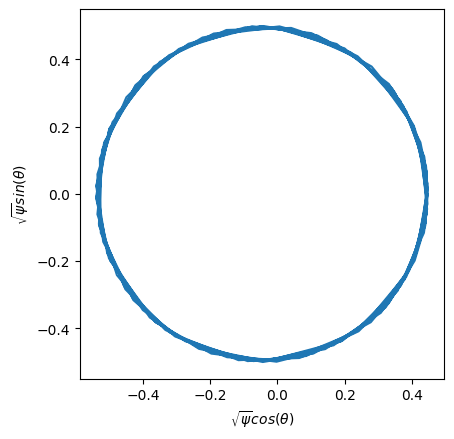

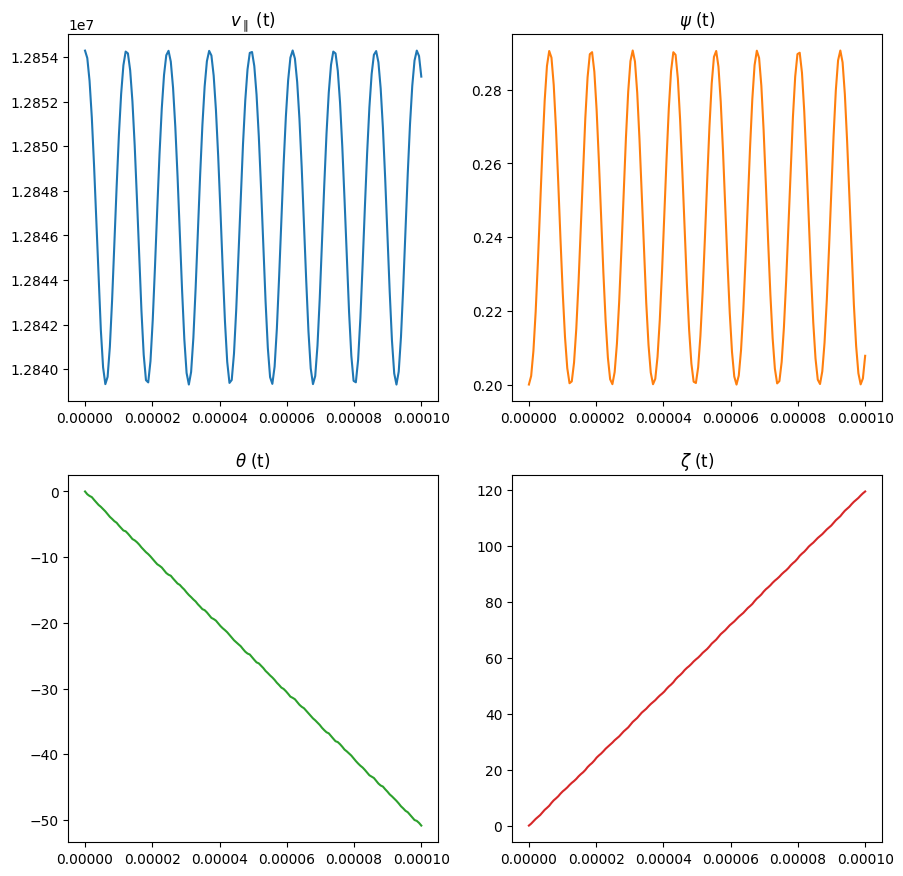

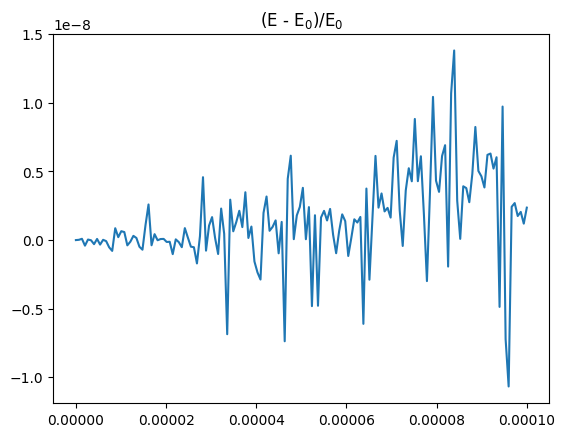

In [10]:
Trajectory_Plot(solution)
Quantity_Plot(time, solution)
Energy_Plot(time, solution, Energy_SI, mu, Mass)

In [18]:
import plot3d as pls

In [16]:
pls.plot_tracing_in_surface(filename, solution)

/home/joaobiu/DESC/desc/io/hdf5_io.py:125: RuntimeWarning:

Save attribute '_anisotropy' was not loaded.

